# storing annotations in SpatialData with tables

## introduction
The `spatialdata` frameowrk supports both the representation of `SpatialElement` (images, labels, points, shapes) and of annotations for these elements. As we will explore in this notebook, some types of `SpatialElement`s can contain some annotatoins within themselves, but the general approach we take is to represent `SpatialElement`s and annotations in separate objects, which allows or more granular control and composability.

For storing annotations we rely on the `AnnData` data structure, and we refer to this object also with the term *table*.

In this notebook we will show the following:

1. how to store annotations in a `SpatialElement` and how to retrieve the indices of their instances:
    1. labels
    4. shapes (circles, polygons/multipolygons)
    5. points
    6. images
2. how to store annotations with `AnnData` tables:
    1. annotating an element with a table
    1. annotating an element with multiple tables
    2. annotating multiple element with a single table
4. operations on tables:
    1. how to retrieve information on what elements a table is annotating
    2. how to change the annotation metadata of a table
    3. how to construct tables that either annotate or do not annotate `SpatialElement`s and how to add them to the SpatialData object
    4. how to perform SQL like joins on tables and `SpatialElement`s in a `SpatialData` object
5. how to perform SQL like joins on tables and SpatialElements in a SpatialData object.

## how to store annotations in a `SpatialElement`

We will consider an example datasets, `blobs`, which contains a copy for each type of `SpatialElement` we support.

In [4]:
from spatialdata.datasets import blobs

sdata = blobs()
sdata

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)


SpatialData object with:
├── Images
│     ├── 'blobs_image': SpatialImage[cyx] (3, 512, 512)
│     └── 'blobs_multiscale_image': MultiscaleSpatialImage[cyx] (3, 512, 512), (3, 256, 256), (3, 128, 128)
├── Labels
│     ├── 'blobs_labels': SpatialImage[yx] (512, 512)
│     └── 'blobs_multiscale_labels': MultiscaleSpatialImage[yx] (512, 512), (256, 256), (128, 128)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     ├── 'blobs_circles': GeoDataFrame shape: (5, 2) (2D shapes)
│     ├── 'blobs_multipolygons': GeoDataFrame shape: (2, 1) (2D shapes)
│     └── 'blobs_polygons': GeoDataFrame shape: (5, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (26, 3)
with coordinate systems:
▸ 'global', with elements:
        blobs_image (Images), blobs_multiscale_image (Images), blobs_labels (Labels), blobs_multiscale_labels (Labels), blobs_points (Points), blobs_circles (Shapes), blobs_multipolygons (Shapes), blobs_polygons (Shapes)

### labels

Labels object cannot contain annotations within themselves; instead, a table is needed for that. Let's see how to compute their indices.

2D and 3D labels have respectively dimensions `('y', 'x')` and `('z', 'y', 'x')`. Given a labels object, the instances are defined by all the pixels whose value is equal to a particular index. In order to identify the indices one can therefore compute the unique values in the labels object (for a multiscale labels the largest resolution should be considered). This is conveniently done by the private function `_get_unique_label_values_as_index()`; 
in one of the next releases we will include this function as a special case of the `get_values()` function, discussed later in the notebook.

Here we show how to use this function to identify the indices of the instances encoded by the labels object, and also how to manually compute this information.

In [19]:
import numpy as np
from spatialdata._core.query.relational_query import _get_unique_label_values_as_index

print(_get_unique_label_values_as_index(sdata["blobs_multiscale_labels"]))
print(np.unique(sdata["blobs_multiscale_labels"]["scale0"]["image"].data.compute()))

Index([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19,
       20, 22, 23, 24, 25, 26, 27, 29, 30],
      dtype='int16')
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26
 27 29 30]


### shapes (circles, polygons/multipolygons)

Shapes are `GeoDataFrame` object, a subclass of `GeoDataFrame` where the geometric information is specified in the `geometry` column. Since they are dataframes, they in particular contain the index, which can be accessed with

In [20]:
sdata["blobs_multipolygons"].index

RangeIndex(start=0, stop=2, step=1)

Circles require a column named `radius` and the rows in the columns `geometry` need to be of type `shapely.Point`. Polygons/multipolygons require the type of the rows in the column `geometry` to be `shapely.Polygon`/`shapely.MultiPolygon`. These are the only requirements, and the extra columns can be used for annotation.

In [30]:
sdata["blobs_circles"]["my_value"] = [0, 0, 0, 0, 1]
sdata["blobs_circles"]

,geometry,radius,my_value
0,POINT (291.062 197.065),51,0
1,POINT (259.026 371.319),51,0
2,POINT (194.973 204.414),51,0
3,POINT (149.926 188.623),51,0
4,POINT (369.422 258.900),51,1


/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:1895: UserWarning: No table found with color column my_value to render blobs_circles
  params = _validate_colors_element_table_mapping_points_shapes(sdata, params, wanted_elements_on_cs)


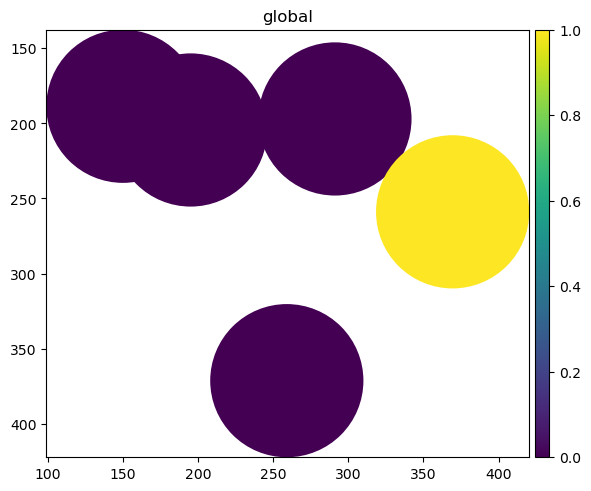

In [31]:
import spatialdata_plot

sdata.pl.render_shapes("blobs_circles", color="my_value").pl.show()

### points

Points are represented as "lazy" (using Dask) pandas dataframes. Similarly as above, they have an index. The spatial information is specified by the `x` and `y` columns (for 2D points) and the `x`, `y`, `z` columns (for 3D points). The rest of the columns can be used to store annotations. The `blobs` dataset already stores some annotations in those columns.

In [36]:
sdata["blobs_points"].compute()

,x,y,genes,instance_id
0,46,395,gene_b,9
1,334,224,gene_b,7
2,221,438,gene_b,3
3,44,356,gene_a,9
4,103,49,gene_b,4
...,...,...,...,...
195,381,92,gene_a,8
196,188,306,gene_b,5
197,368,447,gene_a,7
198,23,101,gene_a,6


/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:1895: UserWarning: No table found with color column genes to render blobs_points
  params = _validate_colors_element_table_mapping_points_shapes(sdata, params, wanted_elements_on_cs)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:102: UserWarning: Key `blobs_points` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:692: FutureWarning: The

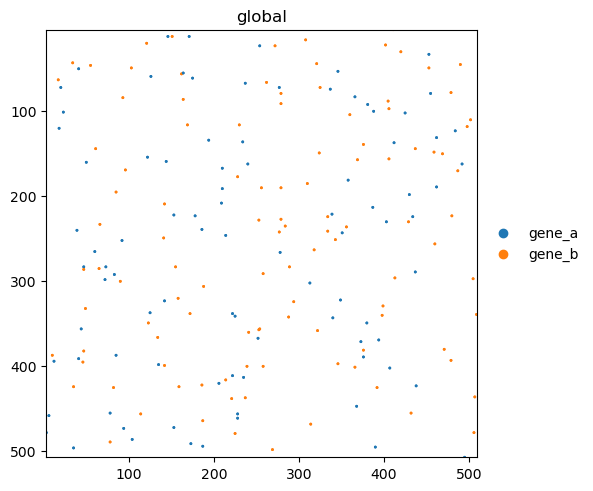

In [37]:
sdata.pl.render_points(color="genes").pl.show()

### images

2D and 3D images have respectively dimensions `('c', 'y', 'x')` and `('c', 'z', 'y', 'x')`. Unlike for the `SpatialElement`s above, images do not contain information on instances and in particular they do not have an index. Nevertheless, the coordinates of the dimension `c` of images can be specified, thus giving a name for each channel.

Channels can be accessed using the utils function `get_channels()`, which operates on both single-scale and multi-scale images.

In [5]:
from spatialdata.models import get_channels

In [6]:
get_channels(sdata["blobs_multiscale_image"])

[0, 1, 2]

The channels can also be accessed directly from the `xarray.DataArray` object. For instance for a single-scale image we have

In [5]:
sdata["blobs_image"].c.values

array([0, 1, 2])

To set the channels we recommend to use the parsers `Image2DModel.parse()` and `Image3DModel.parse()`. For instance

In [7]:
from spatialdata.models import Image2DModel

In [10]:
sdata["blobs_image"] = Image2DModel.parse(sdata["blobs_image"], c_coords=["r", "g", "b"])
get_channels(sdata["blobs_image"])

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:54: UserWarning: Key `blobs_image` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


['r', 'g', 'b']

## how to store annotations with `AnnData` tables

Tables can annotate any `SpatialElement` that have an index, so they can annotate labels, shapes and points. Tables can also be specified without defining the annotation target; images do not have an index so they cannot be annotated by a table, but one could use a table without an annotation target to effectively annotate the channels of the image. Tables cannot annotate tables. 

An `AnnData` table offers a more powerful way to store annotations as opposed to the methods described before. The `AnnData` object can store sparse and dense matrices, multiple layers (=variants) of these matrices, and can store annotations for the rows and columns for these matrices in terms of tensors, dataframes and matrices of pairwise relationships. We refer to the `anndata` documentation (https://anndata.readthedocs.io/en/latest/) for a full description of this and here we limit to the following graphical schematic.

<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" width="500" height="500" />

### annotating an element with a table

Each table contains some metadata that defines the annotation target (if any) of the table. This metadata is constituted by:
- the `region`, `region_key` and `instance_key` triplet, stored in `table.uns`;
- two columns of the `DataFrame` stored in `table.obs`.

A table that doesn't annotate any element doesn't contain any of the above metadata. Instead, in order to define the annotation targets of a table, the above metadata is defined as follows:

- `region` is either a string either a list of strings, and describes the list of targets, i.e. the `SpatialElement`s that the table annotates. 
- `region_key` is a string, and is the name of a column of the dataframe `table.obs` which describes, for each row, which is the `SpatialElement` that the rows refers to;
- `instance_key` is a string, and is the name of a column of the dataframe `table.obs` which describes, for each row, which is the index of the particular annotated instance (which is inside the `SpatialElement` annotated by the row).

A few more details on the two dataframe columns.
- The column named after `region_key` must have string either categorical type; it should nevertheless be categorical and the framework will warn the user to convert it as categorical before performing computationally expensive operations. 
- The column named after `instance_key` must be either have numerical either string type.

Finally, you may notice that the information contained in `region` is redunant (as it can be computed as the list of unique values of the column named after `region_key`) and it may even get out-of-sync (for instance after subsetting the rows). For these reasons, in a future release we will simplify the metadata by dropping `region`, deriving it automatically instead. Anyway, currently we are maintaining it for legacy reasons.


**Warning!** Please note that we haven't mentioned the index of the table. In fact, we do not use the index of the table!

The above information is summarized in the following graphical slide.

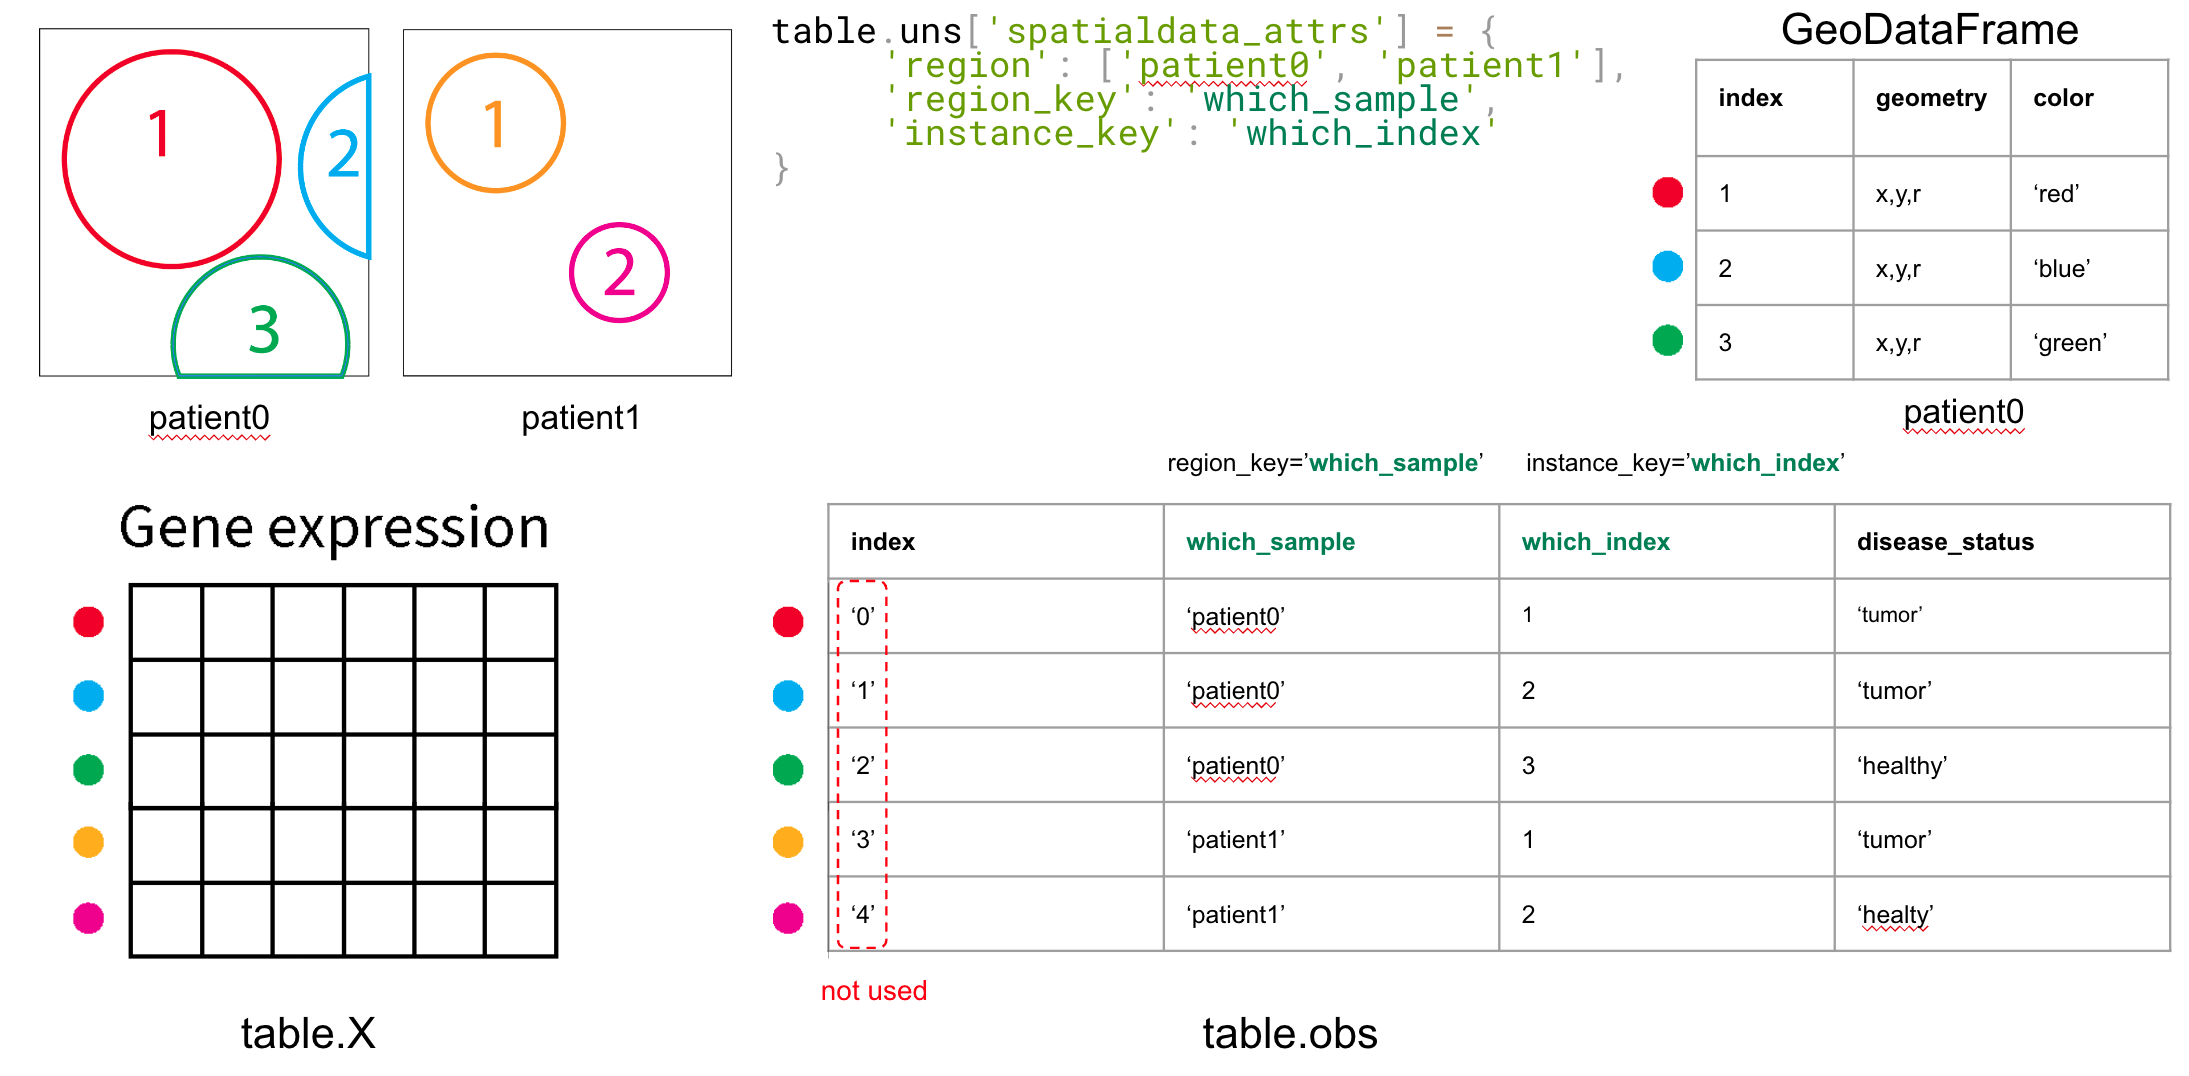

Let's now see an example. Blobs contains one table. Let's see what it is annotating by looking at the `region`, `region_key` and `instance_key` metadata, which can be accessed using the utils function `get_region_key()`.

In [41]:
from spatialdata.models import get_table_keys

region, region_key, instance_key = get_table_keys(sdata["table"])
print(region, region_key, instance_key)

blobs_labels region instance_id


We can see that this information is present in `sdata["table"].obs`. Here `region` are the names of the `SpatialElement`s being annotated, the `region_key` corresponds to the column in `.obs` containing per row which `SpatialElement` is annotated by that row and `instance_key` specifies the column with per row the information which `index` of the `SpatialElement` the table is annotating.

In [43]:
sdata["table"].obs.head()

,instance_id,region
1,1,blobs_labels
2,2,blobs_labels
3,3,blobs_labels
4,4,blobs_labels
5,5,blobs_labels


If we want to retrieve either of the three, there are three helper functions that allow for this, namely `get_annotated_regions`, `get_region_key_column` and `get_instance_key_column`. Either of these take only the `AnnData`table as an argument. Below we show an example:

In [46]:
from spatialdata import SpatialData as sd

regions = sd.get_annotated_regions(sdata["table"])
print(regions)

blobs_labels


In [47]:
region_column = sd.get_region_key_column(sdata["table"])
print(region_column.head())

1    blobs_labels
2    blobs_labels
3    blobs_labels
4    blobs_labels
5    blobs_labels
Name: region, dtype: category
Categories (1, object): ['blobs_labels']


---

In [38]:
### annotating an element with multiple tables;
### annotating multiple element with a single table;
## operations on tables:
### how to retrieve information on what elements a table is annotating.
### how to change the annotation metadata of a table
### how to construct tables that either annotate or do not annotate `SpatialElement`s and how to add them to the SpatialData object.
### how to perform SQL like joins on tables and `SpatialElement`s in a `SpatialData` object.
## how to perform SQL like joins on tables and SpatialElements in a SpatialData object.

## Changing the annotation target of a table
We have a helper function, `set_table_annotates_element` to change the metadata regarding the annotation target of table in a `SpatialData` object. This function takes as arguments the `table_name`, `region` and optionally the `region_key` and `instance_key`. The latter two don't have to necessarily be specified if the table is already annotating a `SpatialElement`. The current values will be reused if not specified. For any of the arguments specified, they must be present at their respective location in the `SpatialData`object or table.

In [5]:
sdata["table"].obs["region"] = "blobs_circles"
sdata.set_table_annotates_spatialelement("table", region="blobs_circles")

## Constructing and adding tables to a SpatialData object
Tables in `Spatialdata` are `AnnData` tables. Creating a table that does not annotate a `SpatialElement` is as simple as constructing an `Anndata` table. In this case the table should not contain `region`, `region_key` and `instance_key` metadata. Here an example of a table storing a dummy codebook:

In [6]:
from anndata import AnnData
from spatialdata.models import TableModel

codebook_table = AnnData(obs={"Gene": ["Gene1", "Gene2", "Gene3"], "barcode": ["03210", "23013", "30121"]})

# We don't specify arguments related to metadata as we don't annotate a SpatialElement.
sdata_table = TableModel.parse(codebook_table)
sdata["codebook"] = sdata_table
sdata["codebook"].obs

,Gene,barcode
0,Gene1,03210
1,Gene2,23013
2,Gene3,30121


Now let us create a table that annotates multiple `SpatialElement`s. Note that the order of 
the indices does not have to match the order of the indices in the `SpatialElement`. To 
showcase this we perform a permutation of the indices. Also, the `dtype`of the index column 
of the `SpatialElement` must match the `dtype` of the `instance_key` column in the table. If 
this is not the case this will result in an error when trying to add the table to the 
`SpatialData` object. Lastly, not every index of the `SpatialElement` has to be present in 
the `instance_key` column of the `SpatialData` table and vice versa. We will later show 
functions to deal with these cases.

In [7]:
polygon_index = list(sdata.shapes["blobs_polygons"].index)
# We have to do a compute here as points are lazily loaded using dask.
point_index = list(sdata["blobs_points"].index.compute())

region_column = ["blobs_polygons"] * len(polygon_index) + ["blobs_points"] * len(point_index)
instance_id_column = polygon_index + point_index

In [8]:
import numpy as np

RNG = np.random.default_rng()
table = AnnData(
    X=np.zeros((len(region_column), 1)),
    obs={"region": region_column, "instance_id": instance_id_column},
)
table = table[RNG.permutation(table.obs.index), :].copy()

# Now we have to specify all 3 annotation metadata fields.
sdata_table = TableModel.parse(
    table, region=["blobs_polygons", "blobs_points"], region_key="region", instance_key="instance_id"
)

# When adding the table now, it is validated for presence of annotation targets in the sdata object.
sdata["annotations"] = sdata_table

C:\Users\w-mv\AppData\Local\Temp\ipykernel_42148\1854800405.py:11: UserWarning: Converting `region_key: region` to categorical dtype.
  sdata_table = TableModel.parse(


### Performing SQL like joins
In order to retrieve (non) matching parts of a `SpatialElement` and the annotating tables we 
can perform SQL like join operations on the table. For this, we have the function 
`join_sdata_spatialelement_table`. It takes as arguments the `SpatialData` object, 
`spatial_element_name` as either a `str` or a list of `str`, `how` which indicates what kind 
of SQL like operation to perform (left, left_exclusive, inner, right or right_exclusive). 
Lastly, if you want the indices to match you can indicate this by passing `left` or `right` 
to the `match_rows` argument. The default here is `no`.
![sql_joins](attachments/joins_small.png)

Let us now showcase the function by first removing some indices from `blobs_polygons`and then 
performing a join.

In [9]:
from spatialdata import join_spatialelement_table

# This leaves the element with 3 shapes
sdata["blobs_polygons"] = sdata["blobs_polygons"][:3]

# We can now do a join with one spatial element
element_dict, table = join_spatialelement_table(
    sdata=sdata, spatial_element_names="blobs_polygons", table_name="annotations", how="left"
)
print(element_dict["blobs_polygons"])
table.obs

                                            geometry
0  POLYGON ((340.197 258.214, 316.177 197.065, 29...
1  POLYGON ((284.141 420.454, 267.249 371.319, 25...
2  POLYGON ((203.195 229.528, 285.506 204.414, 19...


C:\Users\w-mv\PycharmProjects\spatialdata\src\spatialdata\_core\_elements.py:92: UserWarning: Key `blobs_polygons` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
C:\Users\w-mv\PycharmProjects\spatialdata\src\spatialdata\_core\query\relational_query.py:396: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_df = table.obs.groupby(by=region_column_name)


,region,instance_id
0,blobs_polygons,0
1,blobs_polygons,1
2,blobs_polygons,2


Above we see that the table only contains those annotations corresponding to shapes that are 
still in `blobs_polygons`. The `element_dict` only contains `SpatialElement`s used in the 
join. Let us now repeat the join but with the table rows matching the indices of 
`blobs_polygons`.

In [10]:
element_dict, table = join_spatialelement_table(
    sdata=sdata, spatial_element_names="blobs_polygons", table_name="annotations", how="left", match_rows="left"
)
print(element_dict["blobs_polygons"])
table.obs

                                            geometry
0  POLYGON ((340.197 258.214, 316.177 197.065, 29...
1  POLYGON ((284.141 420.454, 267.249 371.319, 25...
2  POLYGON ((203.195 229.528, 285.506 204.414, 19...


C:\Users\w-mv\PycharmProjects\spatialdata\src\spatialdata\_core\query\relational_query.py:396: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_df = table.obs.groupby(by=region_column_name)


,region,instance_id
0,blobs_polygons,0
1,blobs_polygons,1
2,blobs_polygons,2


Let us now add the filtered annotations back to the `SpatialData` object. This requires us to
use a slightly different function then the one we learned about earlier for adjusting the 
annotation metadata.

In [11]:
table = sd.update_annotated_regions_metadata(table)
sdata["filtered_annotations_blobs_polygons"] = table

Lastly, we can also do the join operation on multiple `SpatialElements` at the same time.

In [12]:
element_dict, table = join_spatialelement_table(
    sdata=sdata,
    spatial_element_names=["blobs_polygons", "blobs_points"],
    table_name="annotations",
    how="left",
    match_rows="left",
)
sdata["multi_filtered_table"] = table
table.obs

C:\Users\w-mv\PycharmProjects\spatialdata\src\spatialdata\_core\query\relational_query.py:396: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_df = table.obs.groupby(by=region_column_name)


,region,instance_id
0,blobs_polygons,0
1,blobs_polygons,1
2,blobs_polygons,2
5,blobs_points,0
6,blobs_points,1
...,...,...
200,blobs_points,195
201,blobs_points,196
202,blobs_points,197
203,blobs_points,198


In [13]:
# This tells us which tables we have in the SpatialData object
sdata.tables

{'table': AnnData object with n_obs × n_vars = 26 × 3
    obs: 'instance_id', 'region'
    uns: 'spatialdata_attrs', 'codebook': AnnData object with n_obs × n_vars = 3 × 0
    obs: 'Gene', 'barcode', 'annotations': AnnData object with n_obs × n_vars = 205 × 1
    obs: 'region', 'instance_id'
    uns: 'spatialdata_attrs', 'filtered_annotations_blobs_polygons': AnnData object with n_obs × n_vars = 3 × 1
    obs: 'region', 'instance_id'
    uns: 'spatialdata_attrs', 'multi_filtered_table': AnnData object with n_obs × n_vars = 203 × 1
    obs: 'region', 'instance_id'
    uns: 'spatialdata_attrs'}

So far we have shown that you can do join operations when the elements and the table are both in a `SpatialData` object. However, 
you can also perform this operation on `SpatialElement`s / tables outside `SpatialData` objects:

In [15]:
element_dict, table = join_spatialelement_table(
    spatial_element_names=["blobs_polygons", "blobs_points"],
    elements=[sdata["blobs_polygons"], sdata["blobs_points"]],
    table=sdata["annotations"],
    how="left",
    match_rows="left",
)
sdata["multi_filtered_table"] = table
table.obs

C:\Users\w-mv\PycharmProjects\spatialdata\src\spatialdata\_core\query\relational_query.py:396: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_df = table.obs.groupby(by=region_column_name)
C:\Users\w-mv\PycharmProjects\spatialdata\src\spatialdata\_core\_elements.py:112: UserWarning: Key `multi_filtered_table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


,region,instance_id
0,blobs_polygons,0
1,blobs_polygons,1
2,blobs_polygons,2
5,blobs_points,0
6,blobs_points,1
...,...,...
200,blobs_points,195
201,blobs_points,196
202,blobs_points,197
203,blobs_points,198


### Ending on a special note
For the joins on `Shapes` and `Points` elements any type of join is supported and also any
kind of matching is supported. For `Labels` elements however, only the left join is supported
and also only `no` and `left` are supported for the argument `match_rows`. This because for `Labels` the SQL like join behaviour 
would otherwise be complex to implement due to masking out of particular labels potentially being an expensive operation. We also 
did not forsee a usecase for this. In case you have a use case for this, please get in touch with us by either opening an issue 
on [github](https://github.com/scverse/spatialdata) or via our [discourse](https://discourse.scverse.org/).